In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from collections import Counter
import wfdb

In [2]:
# Contents of dataset
file_list = os.listdir(os.getcwd() + '/qtdb')

## Loading Signal Data

Each set file corresponds to one of the 105 record in the database. Each record consists of 15-minute recordings sampled at 250 hertz, resulting in 225000 samples. Each record has 2 channels, resulting in a signal shape of (225000, 2)

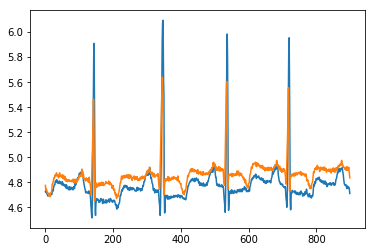

In [3]:
record_id = 'qtdb/sel100'

record = wfdb.rdrecord(record_id)
signal = record.p_signal

# Number of samples per record (225000)
samples_per_record = signal.shape[0]

# Number of samples in each training instance
sample_size = 300

# Number of signal channels (2)
n_channels = signal.shape[1]

# plotting first 300 samples of record
plt.plot(signal[:, 0][:900])
plt.plot(signal[:, 1][:900])

## Loading Annotations

In [4]:
# Signal File: .dat
# Beat Annotation File: .atr
# Wave Marker File: pu0 (channel 0) and pu1 (channel 1)

## Beat annotations are used to extract caridac complexes from the original wave. The extracted cardiac complexes should be padded to 300
## Each beat annotation corresponds to peak point of of the wave
# .atr    reference beat annotations from original database (not available in all cases) [IMPORTANT]
# .man    reference beat annotations [for selected beats only]

## Waveform position annotations
# .qt1    manually determined waveform boundary measurements for selected beats (annotator 1 only -- first pass)
# .q1c    manually determined waveform boundary measurements for selected beats (annotator 1 only -- second pass)
# .pu     automatically determined waveform boundary measurements for all beats (based on both signals) 
# .pu0    automatically determined waveform boundary measurements for all beats (based on signal 0 only) [IMPORTANT]
# .pu1   automatically determined waveform boundary measurements for all beats (based on signal 1 only) [IMPORTANT]

In [5]:
# Get beat annotations

beat_annotation = wfdb.rdann(record_id, extension ='atr')
beat_samples = beat_annotation.sample

# Computing Begin and End points of each interval from beat annotations
intervals = []
intervals.append(0)
for i in range(len(beat_samples)-1):
    intervals.append(int((beat_samples[i] + beat_samples[i+1])/2))
offset = intervals[1]-1

# Get wave annotations
pos_annotation = wfdb.rdann(record_id, extension ='pu0')
label_ids = np.array(pos_annotation.sample)
symbols = np.array(pos_annotation.symbol)

labels = list(zip(pos_annotation.sample, pos_annotation.symbol))

In [6]:
# Generate Input Vector
X = []
for i in range(0,len(intervals)-1):
    # Extract sample from interval values
    sample = signal[:,0][intervals[i]: intervals[i+1]]    
    # Pad sample to 300
    pad_length = sample_size - len(sample)
    #pad_value = np.min(sample)
    pad_value = sample[-1]
    sample = np.concatenate([sample, np.repeat(pad_value, pad_length)])
    sample_concat = np.zeros(300)
    sample_concat[:len(sample)] = sample
    sample_concat[len(sample):] = sample[-1]
    
    # Removing Baseline drift using median filter (given sampling frequency 250hz)
    sample_concat = sample_concat - sg.medfilt(sample_concat, 125)
    X.append(sample_concat)
X = np.array(X)

In [7]:
# Generate target vector

y = []
for i in range(0, len(intervals)-1):
    
    start = intervals[i]
    end = intervals[i+1]
    label_ids_ = label_ids[(label_ids>start) & (label_ids<=end)]
    symbols_ = symbols[np.where((label_ids>start) & (label_ids<=end))[0]]
    label_ids_ = label_ids_ - start
    target = np.zeros(3)
    if 'p' in symbols_:
        target[0] = label_ids_[np.min(np.argwhere(symbols_=='p'))] / 300
    else:
        target[0] = 0.0
    if 'N' in symbols_:
        target[1] = label_ids_[np.min(np.argwhere(symbols_=='N'))] / 300
    else:
        target[1] = 0.0
    if 't' in symbols_:
        target[2] = label_ids_[np.max(np.argwhere(symbols_=='t'))] / 300
    else:
        target[2] = 0.0
    y.append(target)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Reshape, Flatten

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
# Baseline Fully Connected Network

model = Sequential()
model.add(Dense(units=150, input_dim=300, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
759/759 [==============================] - 0s 253us/step - loss: 0.0171
Epoch 2/10
759/759 [==============================] - 0s 59us/step - loss: 0.0033
Epoch 3/10
759/759 [==============================] - 0s 66us/step - loss: 0.0025
Epoch 4/10
759/759 [==============================] - 0s 63us/step - loss: 0.0024
Epoch 5/10
759/759 [==============================] - 0s 66us/step - loss: 0.0023
Epoch 6/10
759/759 [==============================] - 0s 71us/step - loss: 0.0022
Epoch 7/10
759/759 [==============================] - 0s 72us/step - loss: 0.0022
Epoch 8/10
759/759 [==============================] - 0s 63us/step - loss: 0.0021
Epoch 9/10
759/759 [==============================] - 0s 62us/step - loss: 0.0021
Epoch 10/10
759/759 [==============================] - 0s 65us/step - loss: 0.0020


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 453       
Total params: 45,603
Trainable params: 45,603
Non-trainable params: 0
_________________________________________________________________


In [18]:
X_train = X_train.reshape((X_train.shape[0], 300, 1))
X_test = X_test.reshape((X_test.shape[0], 300, 1))

# Convolutional Neural Network Architecture with Dropout

model = Sequential()

model.add(Conv1D(filters=16, kernel_size=5, input_shape=(300, 1), strides=3, padding='same'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(Conv1D(filters=32, kernel_size=5, padding='same', strides=3))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(Flatten())

model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
759/759 [==============================] - 0s 552us/step - loss: 0.0235
Epoch 2/10
759/759 [==============================] - 0s 176us/step - loss: 0.0036
Epoch 3/10
759/759 [==============================] - 0s 177us/step - loss: 0.0027
Epoch 4/10
759/759 [==============================] - 0s 191us/step - loss: 0.0026
Epoch 5/10
759/759 [==============================] - 0s 199us/step - loss: 0.0026
Epoch 6/10
759/759 [==============================] - 0s 186us/step - loss: 0.0025
Epoch 7/10
759/759 [==============================] - 0s 184us/step - loss: 0.0024
Epoch 8/10
759/759 [==============================] - 0s 186us/step - loss: 0.0024
Epoch 9/10
759/759 [==============================] - 0s 196us/step - loss: 0.0024
Epoch 10/10
759/759 [==============================] - 0s 217us/step - loss: 0.0024


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 16)           96        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 32)            2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________